# Nhận diện thiết bị IoT & Phát hiện bất thường bằng Federated Learning

**Notebook này trình bày quy trình đầy đủ xây dựng hệ thống Federated Learning cho bài toán nhận diện thiết bị IoT và phát hiện bất thường, sử dụng dữ liệu thực tế.**

## Nội dung chính
1. Import thư viện & tải dữ liệu
2. Tiền xử lý dữ liệu & chọn đặc trưng
3. Phân chia dữ liệu cho Federated Learning (IID, Non-IID, Quantity Skewed)
4. Huấn luyện mô hình nền tảng (BiLSTM)
5. Chuẩn bị client federated
6. Cài đặt Federated Learning (FedAvg)
7. Vòng lặp huấn luyện liên kết
8. Đánh giá mô hình toàn cục
9. Phân tích & trực quan hóa kết quả

---
**Mục tiêu:**
- Bảo vệ quyền riêng tư dữ liệu
- Đánh giá ảnh hưởng của phân phối dữ liệu đến hiệu năng FL
- So sánh các chiến lược phân chia dữ liệu
- Đề xuất hướng phát triển tiếp theo

In [1]:
# 1. Import thư viện & tải dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
df = pd.read_csv('IoTDIAD.csv')
print('Shape:', df.shape)
df.head()

Shape: (33618, 84)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,192.168.137.66-192.168.137.174-41082-80-6,192.168.137.66,41082.0,192.168.137.174,80.0,6.0,09/08/2022 11:27:38 AM,1527173.0,16.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
1,192.168.137.66-192.168.137.254-55598-34287-6,192.168.137.66,55598.0,192.168.137.254,34287.0,6.0,09/08/2022 11:56:16 AM,9912071.0,7.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
2,192.168.137.174-192.168.137.66-80-47994-6,192.168.137.174,80.0,192.168.137.66,47994.0,6.0,09/08/2022 11:29:10 AM,0.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
3,192.168.137.66-192.168.137.254-59336-8009-6,192.168.137.66,59336.0,192.168.137.254,8009.0,6.0,09/08/2022 11:50:16 AM,349868.0,1.0,1.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
4,192.168.137.66-192.168.137.254-55662-8009-6,192.168.137.66,55662.0,192.168.137.254,8009.0,6.0,09/08/2022 11:49:16 AM,215841.0,1.0,1.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS


Missing values: 0
Label distribution:


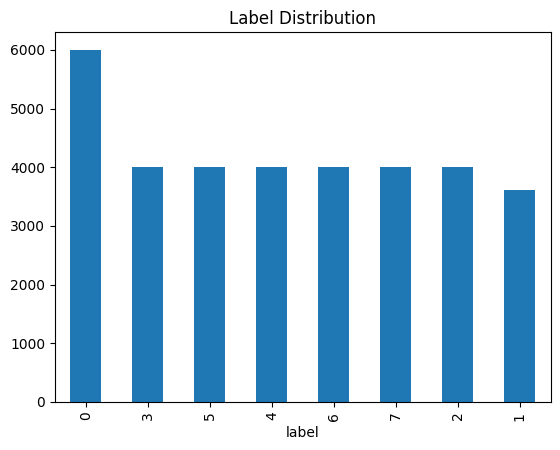

In [2]:
# 2. Tiền xử lý dữ liệu & chọn đặc trưng
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df.drop(columns=['Timestamp'], inplace=True)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['Flow ID'] = df['Flow ID'].astype('category').cat.codes
df['Src IP'] = df['Src IP'].astype('category').cat.codes
df['Dst IP'] = df['Dst IP'].astype('category').cat.codes
df = df.fillna(0)
print('Missing values:', df.isnull().sum().sum())
print('Label distribution:')
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.show()

In [3]:
# Chuyển đổi device sang GPU (CUDA) nếu khả dụng
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Đang sử dụng GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Không tìm thấy GPU, sử dụng CPU')

Đang sử dụng GPU: NVIDIA GeForce RTX 4050 Laptop GPU



=== IID Partition ===
client_0: 8404 samples
  Labels: {0: np.int64(1490), 2: np.int64(1052), 6: np.int64(1023), 4: np.int64(1017), 5: np.int64(1015), 7: np.int64(1007), 3: np.int64(975), 1: np.int64(825)}
client_1: 8404 samples
  Labels: {0: np.int64(1520), 3: np.int64(1038), 5: np.int64(1002), 6: np.int64(1000), 2: np.int64(975), 4: np.int64(973), 7: np.int64(950), 1: np.int64(946)}
client_2: 8404 samples
  Labels: {0: np.int64(1456), 7: np.int64(1038), 4: np.int64(1018), 5: np.int64(1008), 6: np.int64(998), 3: np.int64(978), 2: np.int64(970), 1: np.int64(938)}
client_3: 8406 samples
  Labels: {0: np.int64(1534), 3: np.int64(1009), 7: np.int64(1005), 2: np.int64(1003), 4: np.int64(992), 6: np.int64(979), 5: np.int64(975), 1: np.int64(909)}

Tổng số mẫu: 33618


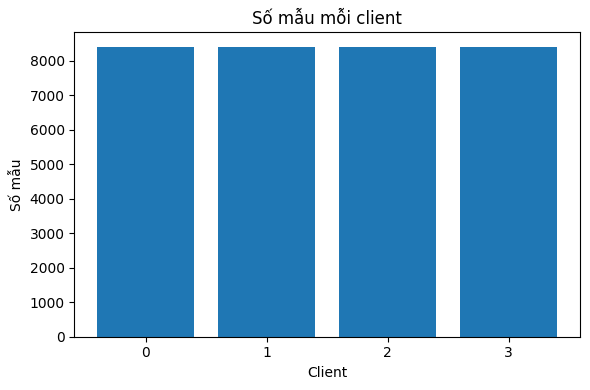


=== Non-IID by Label ===
client_0_label_0: 6000 samples
  Labels: {0: np.int64(6000)}
client_1_label_1: 3618 samples
  Labels: {1: np.int64(3618)}
client_2_label_2: 4000 samples
  Labels: {2: np.int64(4000)}
client_3_label_3: 4000 samples
  Labels: {3: np.int64(4000)}
client_4_label_4: 4000 samples
  Labels: {4: np.int64(4000)}
client_5_label_5: 4000 samples
  Labels: {5: np.int64(4000)}
client_6_label_6: 4000 samples
  Labels: {6: np.int64(4000)}
client_7_label_7: 4000 samples
  Labels: {7: np.int64(4000)}

Tổng số mẫu: 33618


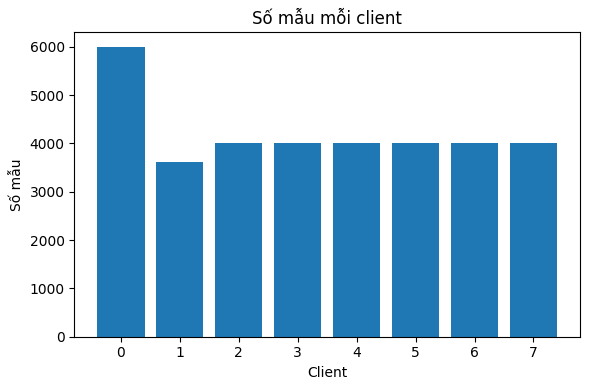


=== Quantity Skewed Partition ===
client_0: 898 samples
  Labels: {0: np.int64(168), 3: np.int64(109), 7: np.int64(109), 6: np.int64(108), 5: np.int64(105), 4: np.int64(100), 1: np.int64(100), 2: np.int64(99)}
client_1: 20044 samples
  Labels: {0: np.int64(3542), 4: np.int64(2410), 5: np.int64(2409), 2: np.int64(2408), 6: np.int64(2396), 7: np.int64(2384), 3: np.int64(2358), 1: np.int64(2137)}
client_2: 8385 samples
  Labels: {0: np.int64(1508), 3: np.int64(1019), 6: np.int64(1011), 7: np.int64(996), 4: np.int64(991), 5: np.int64(987), 2: np.int64(969), 1: np.int64(904)}
client_3: 4291 samples
  Labels: {0: np.int64(782), 2: np.int64(524), 3: np.int64(514), 7: np.int64(511), 4: np.int64(499), 5: np.int64(499), 6: np.int64(485), 1: np.int64(477)}

Tổng số mẫu: 33618

client_0: 898 samples
  Labels: {0: np.int64(168), 3: np.int64(109), 7: np.int64(109), 6: np.int64(108), 5: np.int64(105), 4: np.int64(100), 1: np.int64(100), 2: np.int64(99)}
client_1: 20044 samples
  Labels: {0: np.int64

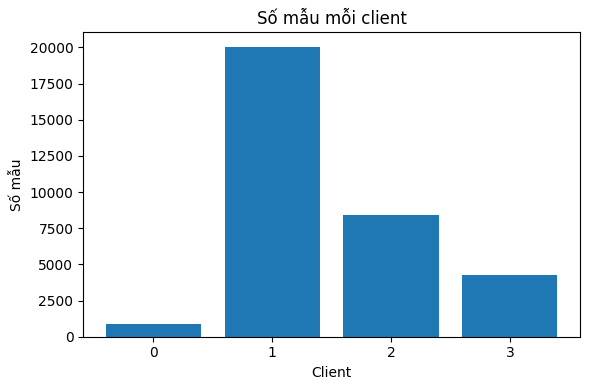

In [18]:
# 3. Phân chia dữ liệu cho Federated Learning
import random
from collections import defaultdict
import matplotlib.ticker as ticker
def create_iid_partition(df, num_clients, random_seed=42):
    np.random.seed(random_seed)
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    samples_per_client = len(df_shuffled) // num_clients
    iid_clients = {}
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = len(df_shuffled) if i == num_clients - 1 else (i + 1) * samples_per_client
        iid_clients[f'client_{i}'] = df_shuffled.iloc[start_idx:end_idx].reset_index(drop=True)
    return iid_clients
def create_non_iid_partition_by_label(df, labels_per_client=1, random_seed=42):
    np.random.seed(random_seed)
    unique_labels = sorted(df['label'].unique())
    non_iid_clients = {}
    if labels_per_client == 1:
        for i, label in enumerate(unique_labels):
            client_data = df[df['label'] == label].reset_index(drop=True)
            non_iid_clients[f'client_{i}_label_{label}'] = client_data
    else:
        random.shuffle(unique_labels)
        num_clients = len(unique_labels) // labels_per_client
        for i in range(num_clients):
            client_labels = unique_labels[i*labels_per_client:(i+1)*labels_per_client]
            client_data = df[df['label'].isin(client_labels)].reset_index(drop=True)
            non_iid_clients[f'client_{i}_labels_{client_labels}'] = client_data
    return non_iid_clients
def create_quantity_skewed_partition(df, num_clients, skew_factor=0.8, random_seed=42):
    np.random.seed(random_seed)
    proportions = np.random.power(skew_factor, num_clients)
    proportions = proportions / proportions.sum()
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    quantity_skewed_clients = {}
    start_idx = 0
    for i in range(num_clients):
        num_samples = int(len(df_shuffled) * proportions[i])
        end_idx = min(start_idx + num_samples, len(df_shuffled))
        if i == num_clients - 1:
            end_idx = len(df_shuffled)
        quantity_skewed_clients[f'client_{i}'] = df_shuffled.iloc[start_idx:end_idx].reset_index(drop=True)
        start_idx = end_idx
    return quantity_skewed_clients
def analyze_partition(client_dict, title="Phân tích phân chia dữ liệu"):
    print(f"\n=== {title} ===")
    total_samples = 0
    label_distribution = defaultdict(int)
    for client_id, client_df in client_dict.items():
        num_samples = len(client_df)
        total_samples += num_samples
        client_labels = client_df['label'].value_counts()
        print(f"{client_id}: {num_samples} samples")
        print(f"  Labels: {dict(client_labels)}")
        for label, count in client_labels.items():
            label_distribution[label] += count
    print(f"\nTổng số mẫu: {total_samples}")
    # Vẽ biểu đồ số mẫu mỗi client, trục x chỉ hiển thị số nguyên
    plt.figure(figsize=(6, 4))
    client_sizes = [len(df) for df in client_dict.values()]
    ax = plt.gca()
    plt.bar(range(len(client_sizes)), client_sizes)
    plt.title('Số mẫu mỗi client')
    plt.xlabel('Client')
    plt.ylabel('Số mẫu')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()
# Tạo các phân chia dữ liệu
iid_clients = create_iid_partition(df, num_clients=4)
analyze_partition(iid_clients, "IID Partition")
non_iid_clients = create_non_iid_partition_by_label(df, labels_per_client=1)
analyze_partition(non_iid_clients, "Non-IID by Label")
quantity_skewed_clients = create_quantity_skewed_partition(df, num_clients=4, skew_factor=0.3)
analyze_partition(quantity_skewed_clients, "Quantity Skewed Partition")

Epoch 10/2000 | Train Acc: 83.13% | Test Acc: 83.48% | Loss: 0.5907
Epoch 20/2000 | Train Acc: 88.30% | Test Acc: 88.62% | Loss: 0.3163
Epoch 30/2000 | Train Acc: 92.02% | Test Acc: 91.60% | Loss: 0.2359
Epoch 40/2000 | Train Acc: 94.65% | Test Acc: 94.21% | Loss: 0.1862
Epoch 50/2000 | Train Acc: 95.66% | Test Acc: 95.09% | Loss: 0.1488
Epoch 60/2000 | Train Acc: 96.59% | Test Acc: 96.17% | Loss: 0.1183
Epoch 70/2000 | Train Acc: 97.36% | Test Acc: 96.94% | Loss: 0.0935
Epoch 80/2000 | Train Acc: 97.93% | Test Acc: 97.47% | Loss: 0.0739
Epoch 90/2000 | Train Acc: 98.38% | Test Acc: 97.76% | Loss: 0.0595
Epoch 100/2000 | Train Acc: 98.78% | Test Acc: 97.99% | Loss: 0.0488
Epoch 110/2000 | Train Acc: 98.97% | Test Acc: 98.16% | Loss: 0.0409
Epoch 120/2000 | Train Acc: 99.23% | Test Acc: 98.35% | Loss: 0.0348
Epoch 130/2000 | Train Acc: 99.34% | Test Acc: 98.38% | Loss: 0.0300
Epoch 140/2000 | Train Acc: 99.45% | Test Acc: 98.55% | Loss: 0.0262
Epoch 150/2000 | Train Acc: 99.55% | Test A

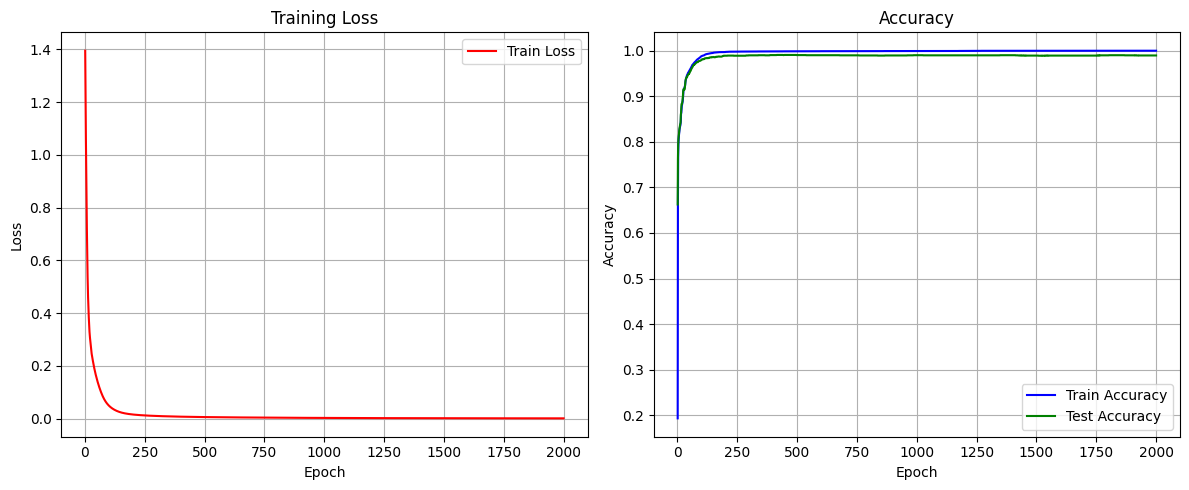

In [7]:
# 4. Huấn luyện mô hình nền tảng (BiLSTM)
foundation_labels = sorted(df['label'].unique())[:4]
df_foundation = df[df['label'].isin(foundation_labels)].reset_index(drop=True)
X_found = df_foundation.drop(columns=['label']).values
y_found = df_foundation['label'].values
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_found, y_found, test_size=0.2, stratify=y_found, random_state=42)
# Xử lý NaN, infinity, giá trị quá lớn/tràn
X_train_f = np.nan_to_num(X_train_f, nan=0, posinf=0, neginf=0)
X_test_f = np.nan_to_num(X_test_f, nan=0, posinf=0, neginf=0)
X_train_f = np.clip(X_train_f, -1e10, 1e10)
X_test_f = np.clip(X_test_f, -1e10, 1e10)

scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
input_size = X_train_f_scaled.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train_f))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 2000
train_accuracies = []
test_accuracies = []
train_losses = []
X_train_tensor = torch.tensor(X_train_f_scaled, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_f_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train_f, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_f, dtype=torch.long).to(device)
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    train_acc = (predicted_train == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_acc = (predicted_test == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}% | Loss: {loss.item():.4f}")
print("\nClassification Report (Foundation Model):")
print(classification_report(y_test_tensor.cpu().numpy(), predicted_test.cpu().numpy(), zero_division=0))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# 5. Chuẩn bị client federated
federated_labels = sorted(df['label'].unique())[4:]
client_data = {}
selected_columns = list(range(input_size))  # Sử dụng toàn bộ đặc trưng đã chọn từ foundation
for label in federated_labels:
    df_client = df[df['label'] == label].reset_index(drop=True)
    X_client = df_client.drop(columns=['label']).values
    y_client = df_client['label'].values
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_client, y_client, test_size=0.2, random_state=42)
    # Xử lý NaN, infinity, giá trị quá lớn/tràn cho từng client
    X_train_c = np.nan_to_num(X_train_c, nan=0, posinf=0, neginf=0)
    X_test_c = np.nan_to_num(X_test_c, nan=0, posinf=0, neginf=0)
    X_train_c = np.clip(X_train_c, -1e10, 1e10)
    X_test_c = np.clip(X_test_c, -1e10, 1e10)
    
    scaler_c = StandardScaler()
    X_train_c_scaled = scaler_c.fit_transform(X_train_c)
    X_test_c_scaled = scaler_c.transform(X_test_c)
    X_train_c_selected = X_train_c_scaled[:, selected_columns]
    X_test_c_selected = X_test_c_scaled[:, selected_columns]
    client_data[label] = {
        'X_train': X_train_c_selected,
        'y_train': y_train_c,
        'X_test': X_test_c_selected,
        'y_test': y_test_c,
        'scaler': scaler_c
    }
    print(f"Client label {label}: Train shape = {X_train_c_selected.shape}, Test shape = {X_test_c_selected.shape}")
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Client label 4: Train shape = (3200, 88), Test shape = (800, 88)
Client label 5: Train shape = (3200, 88), Test shape = (800, 88)
Client label 6: Train shape = (3200, 88), Test shape = (800, 88)
Client label 7: Train shape = (3200, 88), Test shape = (800, 88)


In [11]:
# 6. Cài đặt Federated Learning (FedAvg)
import copy
class FederatedClient:
    def __init__(self, client_id, client_data, model_class, model_params):
        self.client_id = client_id
        self.raw_data = client_data
        self.model_class = model_class
        self.model_params = model_params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.prepare_local_data()
    def prepare_local_data(self):
        X = self.raw_data.drop(columns=['label']).values
        y = self.raw_data['label'].values
        X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
        X = np.clip(X, -1e10, 1e10)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_train_tensor = torch.tensor(self.X_train_scaled, dtype=torch.float32).to(self.device)
        self.X_test_tensor = torch.tensor(self.X_test_scaled, dtype=torch.float32).to(self.device)
        self.y_train_tensor = torch.tensor(self.y_train, dtype=torch.long).to(self.device)
        self.y_test_tensor = torch.tensor(self.y_test, dtype=torch.long).to(self.device)
    def local_train(self, global_weights, local_epochs=5, lr=0.001):
        local_model = self.model_class(**self.model_params).to(self.device)
        local_model.load_state_dict(global_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
        for epoch in range(local_epochs):
            optimizer.zero_grad()
            outputs = local_model(self.X_train_tensor.unsqueeze(1))
            loss = criterion(outputs, self.y_train_tensor)
            if torch.isfinite(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
                optimizer.step()
        updated_weights = {k: v.cpu().clone() for k, v in local_model.state_dict().items()}
        return updated_weights
class FederatedServer:
    def __init__(self, model_class, model_params):
        self.model_class = model_class
        self.model_params = model_params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.global_model = model_class(**model_params).to(self.device)
        self.global_weights = {k: v.cpu().clone() for k, v in self.global_model.state_dict().items()}
    def aggregate_weights(self, client_weights_list):
        if not client_weights_list:
            return self.global_weights
        aggregated_weights = copy.deepcopy(client_weights_list[0])
        for key in aggregated_weights.keys():
            for i in range(1, len(client_weights_list)):
                aggregated_weights[key] += client_weights_list[i][key]
            aggregated_weights[key] = aggregated_weights[key] / len(client_weights_list)
        return aggregated_weights

In [12]:
# 7. Vòng lặp huấn luyện liên kết
num_rounds = 10
local_epochs = 3
model_params = {'input_size': input_size, 'hidden_size': 64, 'num_classes': len(df['label'].unique())}
clients = []
for label, df_client in non_iid_clients.items():
    if len(df_client) > 0:
        clients.append(FederatedClient(label, df_client, BiLSTM, model_params))
server = FederatedServer(BiLSTM, model_params)
train_loss_history = []
global_acc_history = []
for rnd in range(num_rounds):
    print(f'\n--- FedAvg Round {rnd+1}/{num_rounds} ---')
    local_weights = []
    for client in clients:
        updated_weights = client.local_train(server.global_weights, local_epochs=local_epochs)
        local_weights.append(updated_weights)
    server.global_weights = server.aggregate_weights(local_weights)
    # Đánh giá global model trên tất cả client test set
    accs = []
    for client in clients:
        model = BiLSTM(**model_params).to(client.device)
        model.load_state_dict(server.global_weights)
        model.eval()
        with torch.no_grad():
            outputs = model(client.X_test_tensor.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == client.y_test_tensor).float().mean().item()
            accs.append(acc)
    mean_acc = np.mean(accs)
    global_acc_history.append(mean_acc)
    print(f'Round {rnd+1}: Mean global test accuracy = {mean_acc:.4f}')


--- FedAvg Round 1/10 ---
Round 1: Mean global test accuracy = 0.1566

--- FedAvg Round 2/10 ---
Round 2: Mean global test accuracy = 0.1679

--- FedAvg Round 3/10 ---
Round 3: Mean global test accuracy = 0.1808

--- FedAvg Round 4/10 ---
Round 4: Mean global test accuracy = 0.1912

--- FedAvg Round 5/10 ---
Round 5: Mean global test accuracy = 0.2087

--- FedAvg Round 6/10 ---
Round 6: Mean global test accuracy = 0.2236

--- FedAvg Round 7/10 ---
Round 7: Mean global test accuracy = 0.2326

--- FedAvg Round 8/10 ---
Round 8: Mean global test accuracy = 0.2384

--- FedAvg Round 9/10 ---
Round 9: Mean global test accuracy = 0.2409

--- FedAvg Round 10/10 ---
Round 10: Mean global test accuracy = 0.2442


In [13]:
# 8. Đánh giá mô hình toàn cục
final_accs = []
final_f1s = []
for client in clients:
    model = BiLSTM(**model_params).to(client.device)
    model.load_state_dict(server.global_weights)
    model.eval()
    with torch.no_grad():
        outputs = model(client.X_test_tensor.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == client.y_test_tensor).float().mean().item()
        f1 = f1_score(client.y_test_tensor.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
        final_accs.append(acc)
        final_f1s.append(f1)
print('Final global test accuracy (mean):', np.mean(final_accs))
print('Final global test F1-score (mean):', np.mean(final_f1s))

Final global test accuracy (mean): 0.2441830646857852
Final global test F1-score (mean): 0.047598906172772404


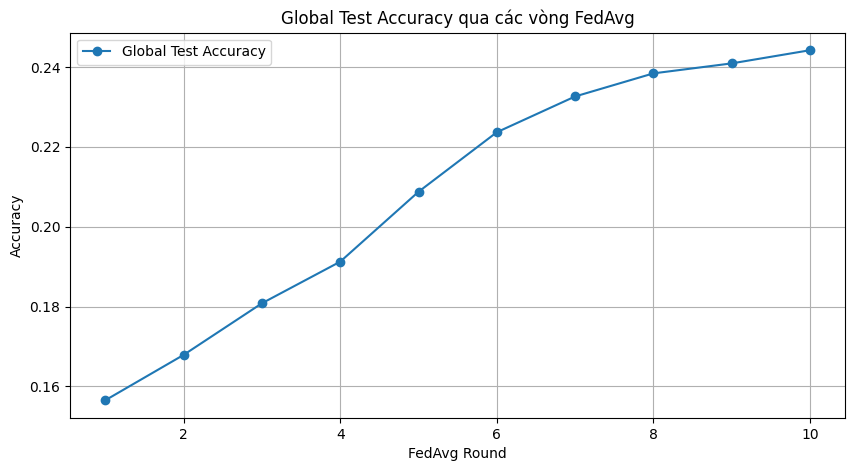

In [14]:
# 9. Phân tích & trực quan hóa kết quả
plt.figure(figsize=(10,5))
plt.plot(range(1, num_rounds+1), global_acc_history, marker='o', label='Global Test Accuracy')
plt.title('Global Test Accuracy qua các vòng FedAvg')
plt.xlabel('FedAvg Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
# So sánh các chiến lược phân chia (ví dụ: IID vs Non-IID)
# Có thể lặp lại các bước trên với iid_clients, quantity_skewed_clients và vẽ nhiều đường trên cùng biểu đồ